# Portfolio trading strategy example

This example demonstrates how to run a backtest with multiple assets, i.e.
trading a portfolio of assets.

The price data is loaded from a CSV file containing daily close prices for
the stocks AAPL, NVDA, TSLA, and GE, ranging from 2022-01-03 to 2024-04-22.

The strategy buys one stock if the last 5 days were positive,
and sells it again if the last 2 days were negative.
Each trade is executed at a fee of 0.1%.

When missing data points are detected for a stock,
all open positions for that stock are closed.
Logic of this type is common in real-world strategies
and harder to implement in a vectorized way,
showcasing the flexibility of Fastback.

The account equity, balance and drawdowns are collected for
every day and plotted at the end using the Plots package.
Additionally, the performance and P&L breakdown of each stock is plotted
and statistics (avg. P&L, worst P&L, best P&L, win rate) are printed.

In [1]:
using Fastback
using Dates
using CSV
using DataFrames

# load CSV daily stock data for symbols AAPL, NVDA, TSLA, GE
df_csv = DataFrame(CSV.File("../data/stocks_1d.csv"; dateformat="yyyy-mm-dd HH:MM:SS"));
df_csv.symbol = Symbol.(df_csv.symbol); # convert string to symbol type
df = unstack(df_csv, :dt_close, :symbol, :close) # pivot long to wide format
symbols = Symbol.(names(df)[2:end]);

# print summary
describe(df)

# create trading account with $100'000 start capital
base_asset = Asset(1, :USD);
acc = Account{Nothing,Nothing}(base_asset);
add_funds!(acc, base_asset, 100_000.0);

# register instruments for all symbols
instruments = map(((i, symbol),) -> Instrument(i, symbol, symbol, :USD), enumerate(symbols));
register_instrument!.(Ref(acc), instruments);

# data collector for account balance, equity and drawdowns (sampling every day)
collect_balance, balance_data = periodic_collector(Float64, Day(1));
collect_equity, equity_data = periodic_collector(Float64, Day(1));
collect_drawdown, drawdown_data = drawdown_collector(DrawdownMode.Percentage, Day(1));

function open_position!(acc, inst, dt, price)
    # invest 20% of equity in the position
    qty = 0.2total_equity(acc) / price
    order = Order(oid!(acc), inst, dt, price, qty)
    fill_order!(acc, order, dt, price; fee_pct=0.001)
end

function close_position!(acc, inst, dt, price)
    # close position for instrument, if any
    pos = get_position(acc, inst)
    has_exposure(pos) || return
    order = Order(oid!(acc), inst, dt, price, -pos.quantity)
    fill_order!(acc, order, dt, price; fee_pct=0.001)
end

# loop over each row of DataFrame
for i in 6:nrow(df)
    row = df[i, :]
    dt = row.dt_close

    # loop over all instruments and check strategy rules
    for inst in instruments
        price = row[inst.symbol]

        window_open = @view df[i-5:i, inst.symbol]
        window_close = @view df[i-2:i, inst.symbol]

        # close position of instrument if missing data
        if any(ismissing.(window_open))
            close_price = get_position(acc, inst).avg_price
            close_position!(acc, inst, dt, close_price)
            continue
        end

        if !is_exposed_to(acc, inst)
            # buy if last 5 days were positive
            all(diff(window_open) .> 0) && open_position!(acc, inst, dt, price)
        else
            # close position if last 2 days were negative
            all(diff(window_close) .< 0) && close_position!(acc, inst, dt, price)
        end

        # update position and account P&L
        update_pnl!(acc, inst, price)
    end

    # close all positions at the end of backtest
    if i == nrow(df)
        for inst in instruments
            price = row[inst.symbol]
            close_position!(acc, inst, dt, price)
        end
    end

    # collect data for plotting
    if should_collect(equity_data, dt)
        equity = total_equity(acc)
        collect_balance(dt, total_balance(acc))
        collect_equity(dt, equity)
        collect_drawdown(dt, equity)
    end
end

# print account statistics
show(acc)


━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ ACCOUNT SUMMARY ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Balance:     134906.50
Equity:      134906.50
Assets:      1
┌────────┬───────────┐
│ Symbol │     Value │
├────────┼───────────┤
│    USD │ 134906.50 │
└────────┴───────────┘
Positions:   0
Trades:      76
┌─────┬────────┬───────────────────────────┬──────────┬─────────────┬────────────┬──────────────┬───────┐
│ Seq │ Symbol │                      Date │ Fill qty │ Remain. qty │ Fill price │ Realized P&L │   Fee │
├─────┼────────┼───────────────────────────┼──────────┼─────────────┼────────────┼──────────────┼───────┤
│   1 │     GE │ 2022-02-02 21:00:00 +0 ms │   263.24 │        0.00 │      75.98 │       -20.00 │ 20.00 │
│   2 │     GE │ 2022-02-09 21:00:00 +0 ms │  -263.24 │        0.00 │      76.91 │       226.59 │ 20.25 │
│   3 │     GE │ 2022-03-14 20:00:00 +0 ms │   279.48 │        0.00 │      71.71 │       -20.04 │ 20.04 │
│   4 │   AAPL │ 2022-03-21 20:00:00 +0 ms │   123.38 │        0.00 │     16

### Plot account balance, equity, drawdowns and stocks performance

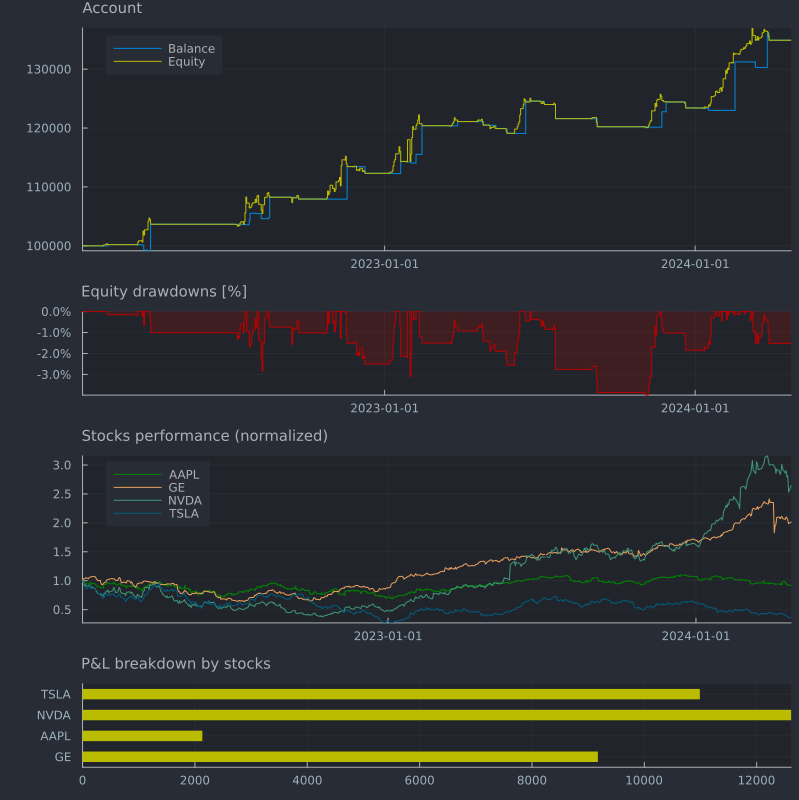

In [2]:
using Plots, Query, Printf, Measures

theme(:juno; titlelocation=:left, titlefontsize=10, widen=false, fg_legend=:false)

# equity / balance
p1 = plot(
    dates(balance_data), values(balance_data);
    title="Account",
    label="Balance",
    linetype=:steppost,
    yformatter=:plain,
    color="#0088DD");
plot!(p1,
    dates(equity_data), values(equity_data);
    label="Equity",
    linetype=:steppost,
    color="#BBBB00");

# drawdowns
p2 = plot(
    dates(drawdown_data), 100values(drawdown_data);
    title="Equity drawdowns [%]",
    legend=false,
    color="#BB0000",
    yformatter=y -> @sprintf("%.1f%%", y),
    linetype=:steppost,
    fill=(0, "#BB000033"));

# stocks performance
p3 = plot(
    df.dt_close, df[!, 2] ./ df[1, 2];
    title="Stocks performance (normalized)",
    yformatter=y -> @sprintf("%.1f", y),
    label=names(df)[2],
    linetype=:steppost,
    color=:green);
for i in 3:ncol(df)
    plot!(p3,
        df.dt_close, df[!, i] ./ df[1, i];
        label=names(df)[i])
end

# P&L breakdown by stocks
pnl_by_inst = acc.trades |>
              @groupby(_.order.inst.symbol) |>
              @map({
                  symbol = key(_),
                  pnl = sum(getfield.(_, :realized_pnl))
              }) |> DataFrame
p4 = bar(string.(pnl_by_inst.symbol), pnl_by_inst.pnl;
    legend=false,
    title="P&L breakdown by stocks",
    permute=(:x, :y),
    xlims=(0, size(pnl_by_inst)[1]),
    yformatter=y -> @sprintf("%.0f", y),
    color="#BBBB00",
    linecolor=nothing,
    bar_width=0.5)

plot(p1, p2, p3, p4;
    layout=@layout[a{0.4h}; b{0.15h}; c{0.3h}; d{0.15h}],
    size=(800, 800), margin=0mm, left_margin=5mm)

### Calculate statistics per stock

Calculates summary statistics for each stock. Using the `Query.jl` package,
all trades are first grouped by instrument symbol, then average P&L,
worst P&L, best P&L, and win rate are calculated.
Finally, the results are piped into a `DataFrame` and printed
using the `PrettyTables.jl` package.

In [3]:
using PrettyTables

df = acc.trades |>
@groupby(_.order.inst.symbol) |>
@map({
    symbol = key(_),
    avg_pnl = sum(getfield.(_, :realized_pnl)) / length(_),
    worst_pnl = minimum(getfield.(_, :realized_pnl)),
    best_pnl = maximum(getfield.(_, :realized_pnl)),
    win_rate = round.(count(getfield.(_, :realized_pnl) .> 0) / count(is_realizing.(_)), sigdigits=2),
}) |> DataFrame

pretty_table(df; header=["Symbol", "Avg P&L", "Worst P&L", "Best P&L", "Win Rate"])

┌────────┬─────────┬───────────┬──────────┬──────────┐
│ Symbol │ Avg P&L │ Worst P&L │ Best P&L │ Win Rate │
├────────┼─────────┼───────────┼──────────┼──────────┤
│     GE │ 382.206 │  -1116.54 │  5835.66 │     0.42 │
│   AAPL │ 266.522 │  -1357.63 │  1662.75 │     0.75 │
│   NVDA │  485.12 │  -1195.29 │  8258.77 │     0.54 │
│   TSLA │ 610.459 │  -2369.28 │  5524.12 │     0.56 │
└────────┴─────────┴───────────┴──────────┴──────────┘
